# Проект: классификация

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from  sklearn.ensemble import IsolationForest
# import warnings
# warnings.filterwarnings('ignore')

from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split 
from sklearn.feature_selection import SelectKBest, f_classif

In [2]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing  import LabelEncoder

In [3]:
from sklearn.model_selection import GridSearchCV

In [4]:
plt.style.use('seaborn-v0_8')

## Часть 1. Знакомство с данными, обработка пропусков и выбросов

### Задание 1

In [5]:
df = pd.read_csv('data/bank_fin.csv', sep = ';')

Данные о клиентах банка:

    age (возраст);
    job (сфера занятости);
    marital (семейное положение);
    education (уровень образования);
    default (имеется ли просроченный кредит);
    housing (имеется ли кредит на жильё);
    loan (имеется ли кредит на личные нужды);
    balance (баланс).

Данные, связанные с последним контактом в контексте текущей маркетинговой кампании: 

    contact (тип контакта с клиентом);
    month (месяц, в котором был последний контакт);
    day (день, в который был последний контакт);
    duration (продолжительность контакта в секундах).

Прочие признаки:

    campaign (количество контактов с этим клиентом в течение текущей кампании);
    pdays (количество пропущенных дней с момента последней маркетинговой кампании до контакта в текущей кампании);
    previous (количество контактов до текущей кампании)
    poutcome (результат прошлой маркетинговой кампании).

И, разумеется, наша целевая переменная deposit, которая определяет, согласится ли клиент открыть депозит в банке. Именно её мы будем пытаться предсказать в данном кейсе.

In [6]:
# просмотр дубликатов
print('Количество дубликатов: {}'.format(df[df.duplicated()].shape[0]))

# # Удаляем дубликаты:
# df = df.drop_duplicates()
# print('Размер таблицы после удаления дубликатов: {}'.format(data.shape))


Количество дубликатов: 0


In [7]:
# исследуем данные на предмет пропусков
df.isna().sum()

age           0
job           0
marital       0
education     0
default       0
balance      25
housing       0
loan          0
contact       0
day           0
month         0
duration      0
campaign      0
pdays         0
previous      0
poutcome      0
deposit       0
dtype: int64

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11137 non-null  object
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(6), object(11)
memory usage: 1.4+ MB


Пропуски в явном виде в признаке balance с типом данных object

In [9]:
# просмотрим на статистику числовых и категориальных признаков
types = df.dtypes
cat_features = list(types[(types == 'object')].index) #категориальные признаки
num_features = list(types[(types != 'object')].index) #числовые признаки

display(df[num_features].describe())
print('-----------------------------------------------------------')
display(df[cat_features].describe(datetime_is_numeric=False))


,age,day,duration,campaign,pdays,previous
count,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000
mean,41.231948,15.658036,371.993818,2.508421,51.330407,0.832557
std,11.913369,8.420740,347.128386,2.722077,108.758282,2.292007
min,18.000000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,32.000000,8.000000,138.000000,1.000000,-1.000000,0.000000
50%,39.000000,15.000000,255.000000,2.000000,-1.000000,0.000000
75%,49.000000,22.000000,496.000000,3.000000,20.750000,1.000000
max,95.000000,31.000000,3881.000000,63.000000,854.000000,58.000000


-----------------------------------------------------------


,job,marital,education,default,balance,housing,loan,contact,month,poutcome,deposit
count,11162,11162,11162,11162,11137,11162,11162,11162,11162,11162,11162
unique,12,3,4,2,3802,2,2,3,12,4,2
top,management,married,secondary,no,0 $,no,no,cellular,may,unknown,no
freq,2566,6351,5476,10994,774,5881,9702,8042,2824,8326,5873


Для числовых признаков не выявлено аномалий. Возможно в 'pdays' -1 необходимо заменить на 0(контакты с 'pdays' -1 имеют '0'  контактов до текущей кампании('previous'))

Признак balance явно числовой, сделаем необходимые преобразования и заполним там пропуски

In [10]:
# преобразуйте признак balance таким образом, чтобы он корректно считывался, как вещественное число (float)
df['balance'] = df['balance'].apply(lambda x: (str(x)
                                               .replace(' ', '')
                                               .replace(',', '.')
                                               .replace('$', '')
                                               )
                                    ).astype('float64')

In [11]:
# обработайте пропуски в признаки balance 
df['balance']  = df['balance'].fillna(df['balance'].mode()[0])

In [12]:
# сформируем новые списки типов данных
types = df.dtypes
cat_features = list(types[(types == 'object')].index) #категориальные признаки
num_features = list(types[(types != 'object')].index) #числовые признаки

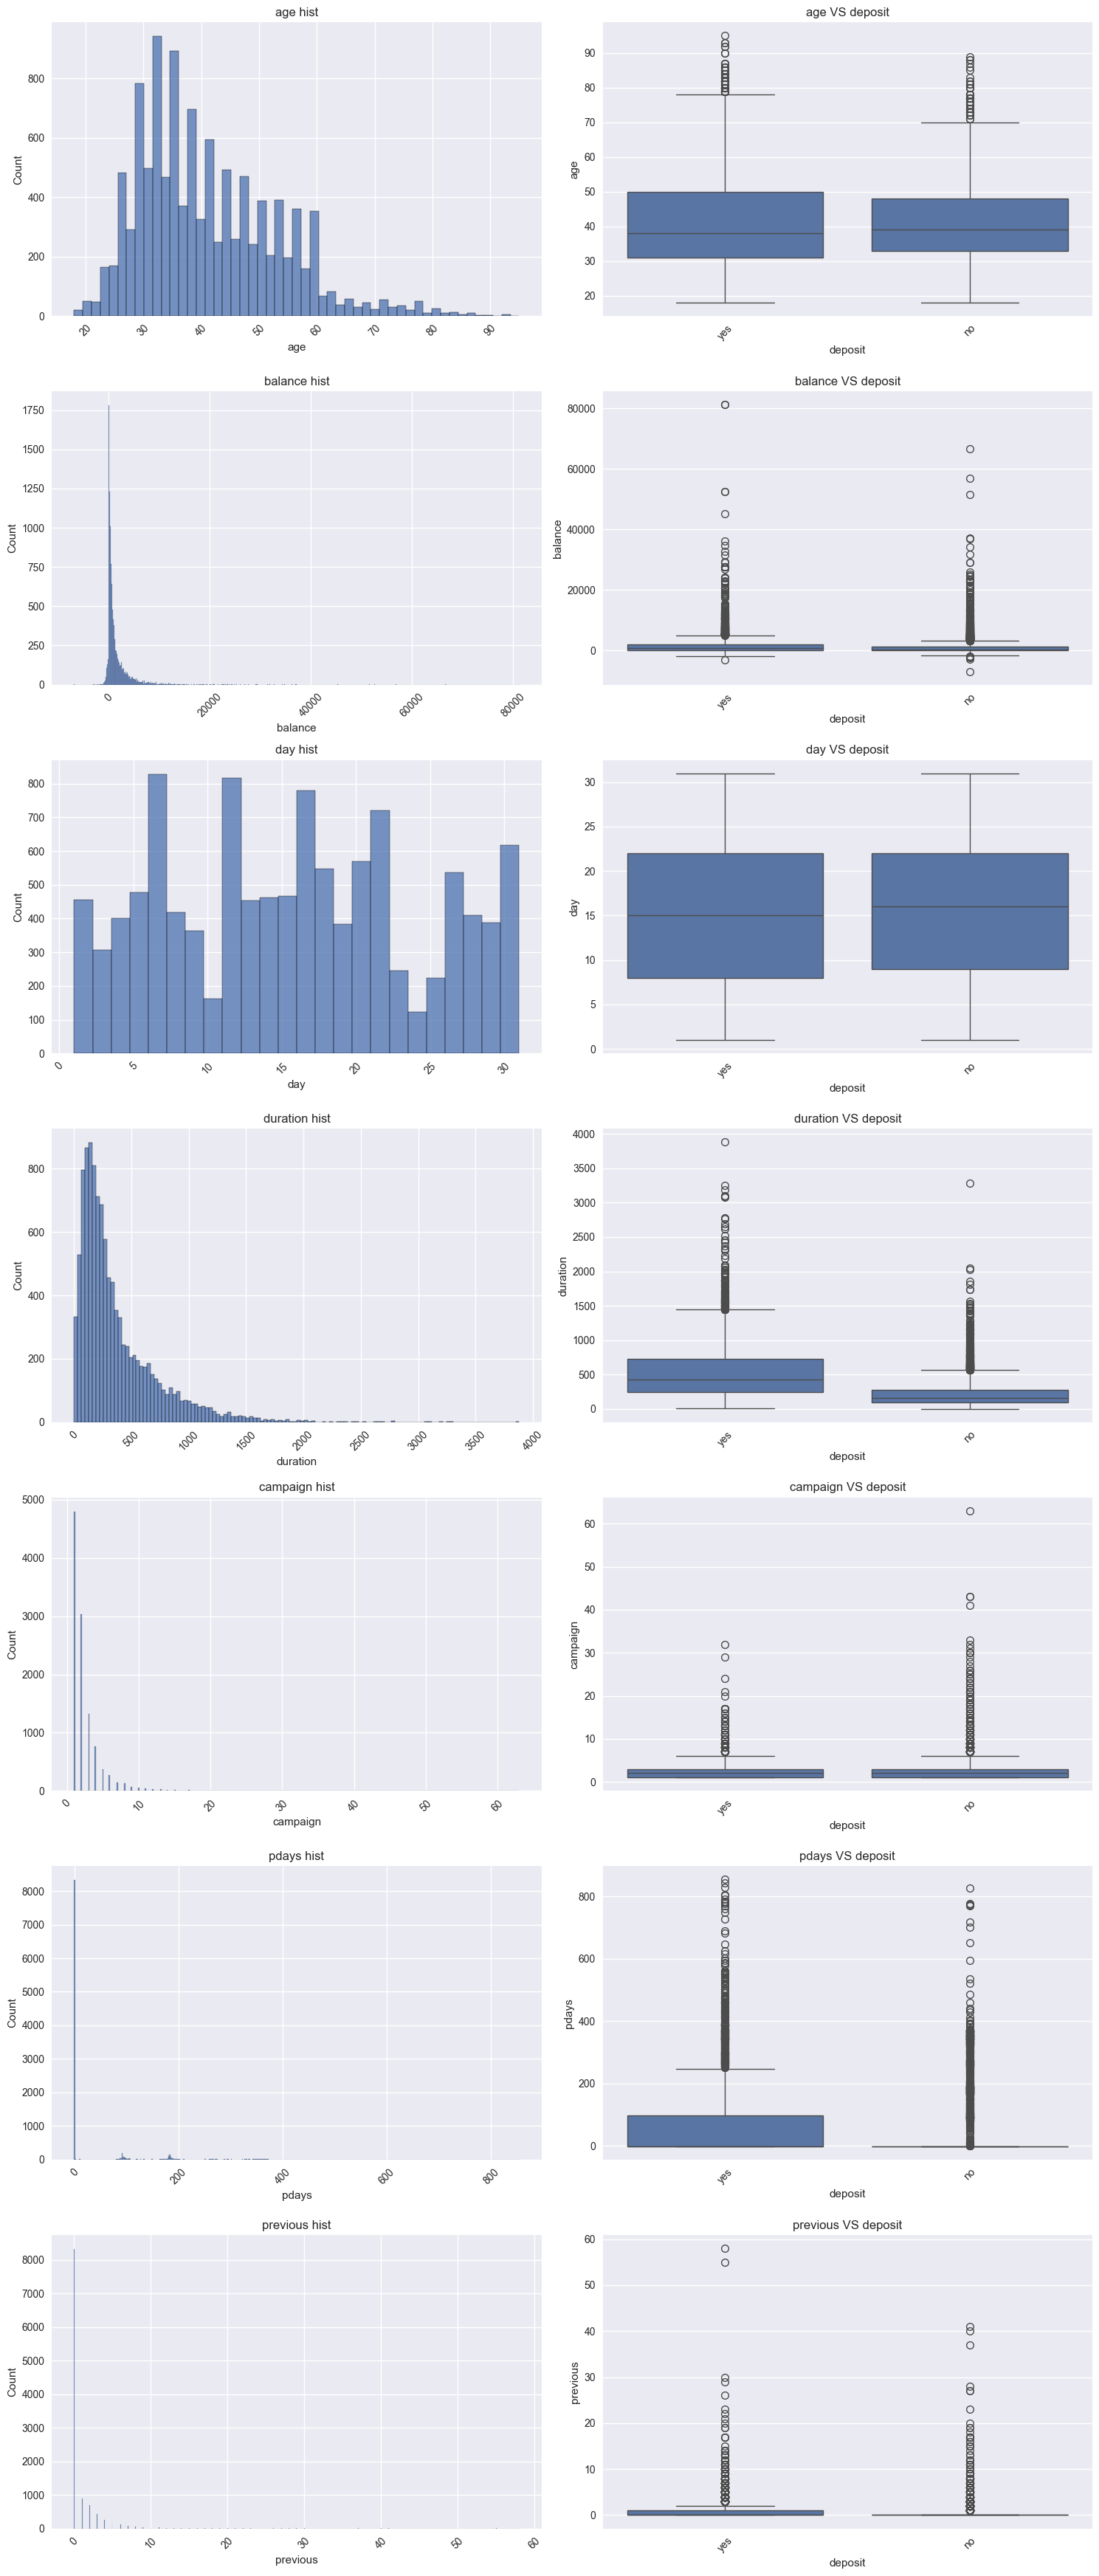

In [13]:
# Визуализируем распределение числовых признаков
def num_plot(num_features, df):
    n = len(num_features) #количество числовых признаков
    fig, axes = plt.subplots(n, 2, figsize=(15, n*5), squeeze=False) # фигура + n х 2 координатных плоскостей
    #Создаем цикл для всех признаков из списка числовых признаков
    for i, feature in enumerate(num_features): #i- индекс, feature - название признака в таблице
        #Строим гистограмму распределения признака 
        histplot = sns.histplot(data=df, x=feature, ax=axes[i][0])
    
        #Добавляем подпись графику
        histplot.set_title('{} hist'.format(feature))
        #Добавляем поворот отметок на оси абсцисс
        histplot.xaxis.set_tick_params(rotation=45)
    
        #Строим ящик 
        boxplot = sns.boxplot(data=df, y=feature, x='deposit', ax=axes[i][1])    
        #Добавляем подпись графику
        boxplot.set_title('{} VS deposit'.format(feature));
        #Добавляем поворот отметок на оси абсцисс
        boxplot.xaxis.set_tick_params(rotation=45)
    plt.tight_layout() #выравнивание графиков
    return

num_plot(num_features, df)

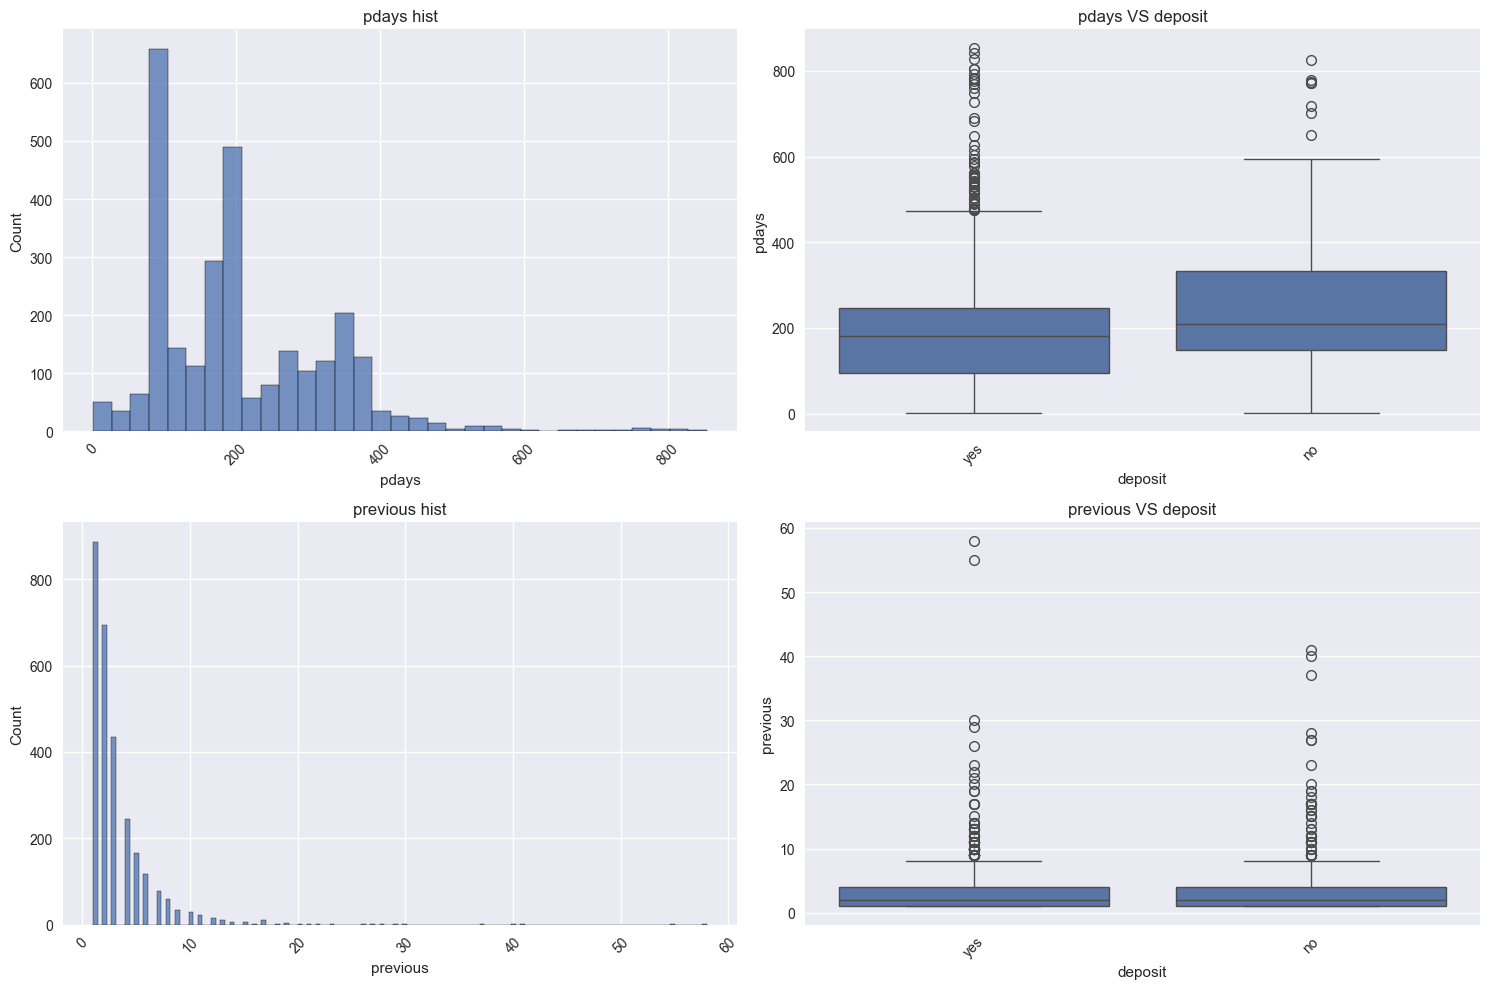

In [14]:
# Посмотрим на признаки pdays и previous без нулей
df_p_p = df[(df['pdays'] != -1)]
num_plot(['pdays', 'previous'], df_p_p)


Особых закономерностей не было замечено. У признаков не нормальное распределение(кроме balance, age и duration: логнормальное)
Возможно есть выбросы у следующих balance, duration, campaign,  previous,

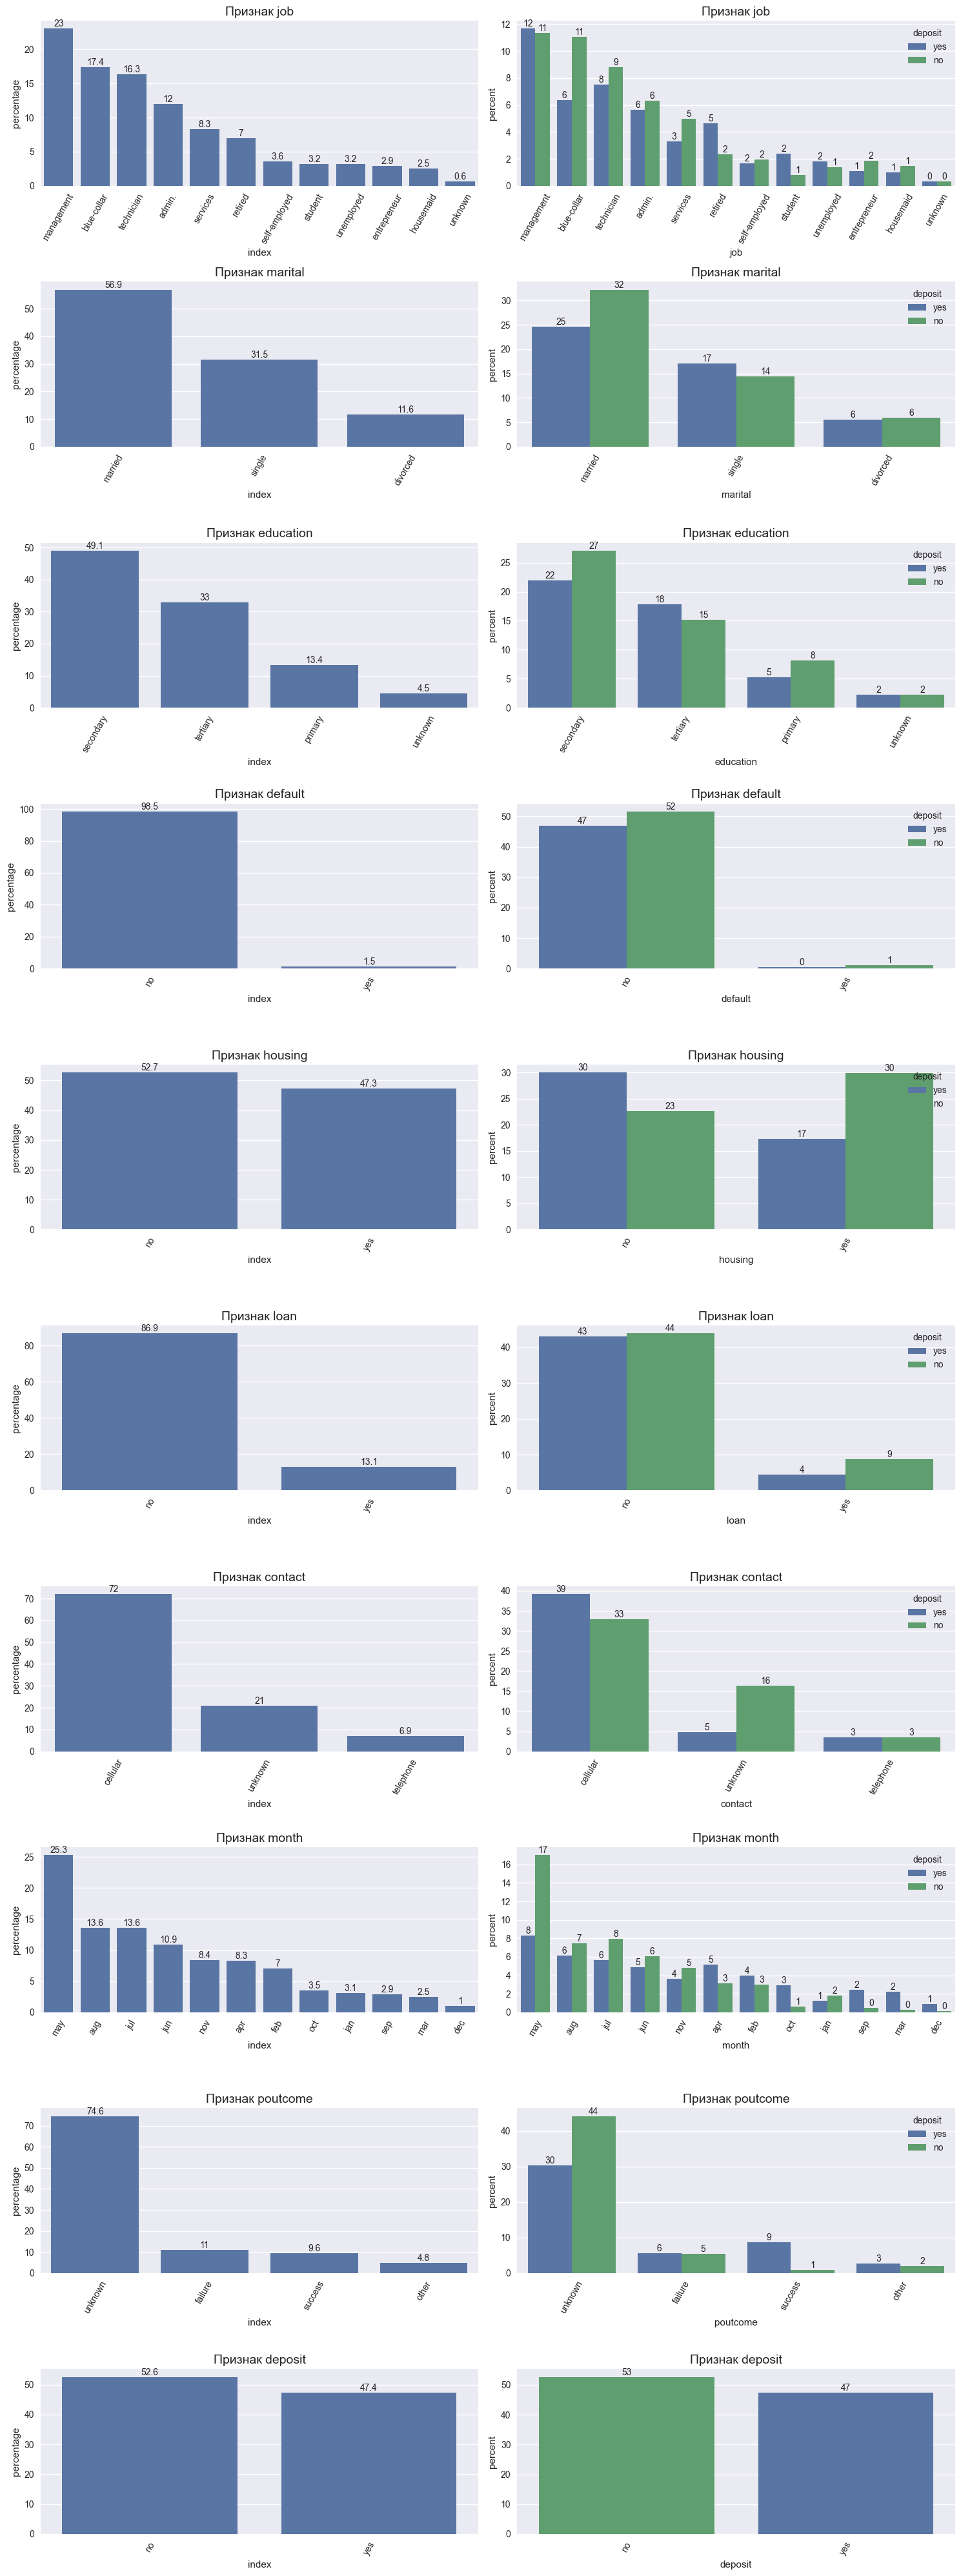

In [15]:
# Визуализируем категориальные признаки
def plot_features(cat_features):
    n = len(cat_features) #число категориальных признаков
    fig, axes = plt.subplots(n, 2, figsize=(15, 4*n), squeeze=False) #всегда 2-х мер массив) #фигура+n*2 координатных плоско-стей
    #Создаём цикл для всех признаков из списка категориальных признаков
    for i, feature in enumerate(cat_features):
        # отсортированный признак в процентах
        df_feature_sort = (df[feature].value_counts(normalize=True, ascending=False)*100).round(1)
        #Строим количественную столбчатую диаграмму для долевого соотношения каждой из категорий в данных
        count_data = (df_feature_sort
                    .rename('percentage')
                    .reset_index())
        count_barplot = sns.barplot(data=count_data, 
                                    x='index', 
                                    y='percentage', 
                                    ax=axes[i, 0],
                                    )
        count_barplot.xaxis.set_tick_params(rotation=60)
        count_barplot.bar_label(count_barplot.containers[0]) # добавление чисел к столбцам
        count_barplot.set_title(f'Признак {feature}', fontsize=14)
        #Строим столбчатую диаграмму наличия депозита по категориям признака
        count_plot = sns.countplot(data=df, 
                                    x=feature, 
                                    hue='deposit',
                                    order = df_feature_sort.index, # порядок столбцов
                                    stat = 'percent', # проценты 13 версия
                                    ax=axes[i, 1],
                                    )
        count_plot.xaxis.set_tick_params(rotation=60)
        count_plot.set_title(f'Признак {feature}', fontsize=14)
        for container in count_plot.containers:
            count_plot.bar_label(container, fmt='%.0f') # добавление чисел к столбцам когда есть hue
    plt.tight_layout() #выравнивание графиков
    return

plot_features(cat_features)   

Выводы:
1. В категории education есть пропуски скрываются за словом 'unknown'




In [16]:
# обработайте пропуски в категориальных признаках: education, заменив их на модальные значения
df['education'] = df['education'].apply(lambda x: df['education'].mode()[0] if x == 'unknown' else x)

In [17]:
# удалите все выбросы для признака balance

In [18]:
# num_plot(['balance'],df[
#                         (df['balance']>500) 
#                         & 
#                         (df['balance']<2000)
#                         ]
#                         )


In [19]:
# from  sklearn.ensemble import IsolationForest
 
 
# X_df = df.drop(columns = 'deposit')
# y_df = df['deposit']
# # ищем выбросы в обучающей выборке
# iso = IsolationForest(contamination=0.1)
# y_predicted = iso.fit_predict(X_df)
 
# # выберем все строки, которые не являются выбросами
# mask = y_predicted != -1
# X_df, y_df = X_df[mask], y_df[mask]
 
# print(X_df.shape, y_df.shape)


In [20]:
# удалите все выбросы для признака balance
# ваш код
def outliers_iqr_mod(data, feature, left=1.5, right=1.5, log_scale=False):
    if log_scale:
        x = np.log(data[feature]-data[feature].min()+0.001)        
    else:
        x= data[feature]
    x.hist() #проверка распределения
    print(x.count())
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * left)
    upper_bound = quartile_3 + (iqr * right)
    print(lower_bound, upper_bound)
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x >= lower_bound) & (x <= upper_bound)]
    return outliers, cleaned



11162
8.542522246583122 9.359636625198558
Число выбросов по методу Тьюки: 837
Результирующее число записей: 10325


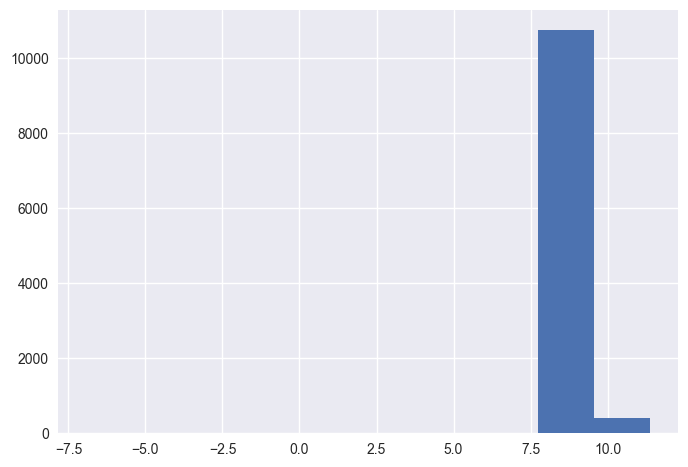

In [21]:
outliers, cleaned = outliers_iqr_mod(df, 'balance', log_scale=True
                                        )
print(f'Число выбросов по методу Тьюки: {outliers.shape[0]}')
print(f'Результирующее число записей: {cleaned.shape[0]}')


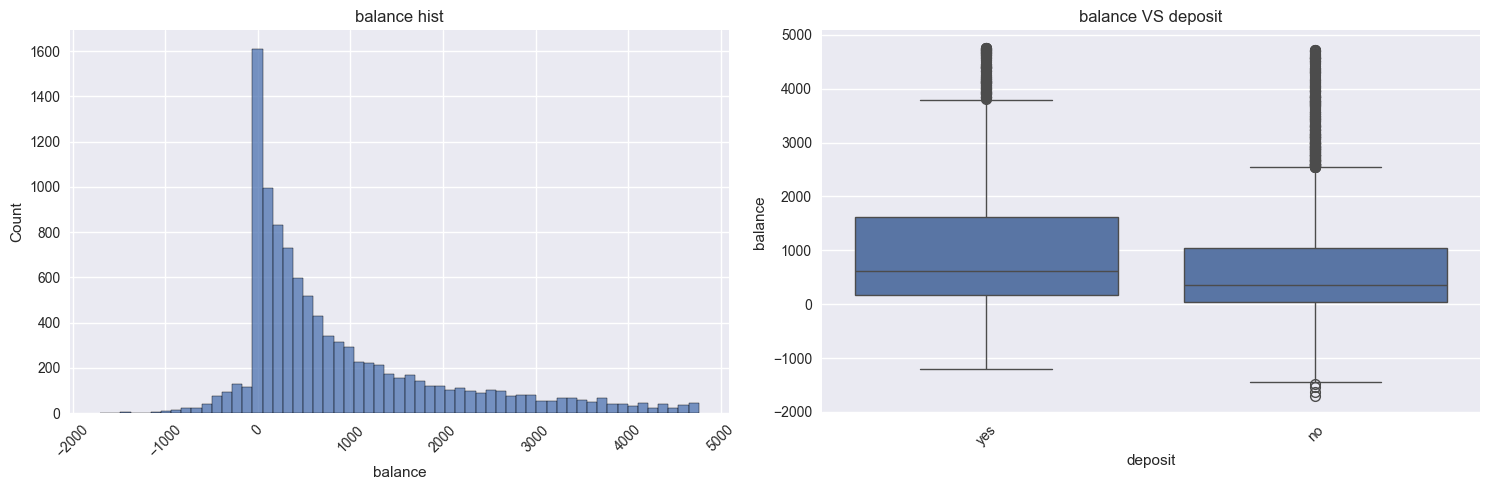

In [22]:
num_plot(['balance'], cleaned)

In [23]:
df = cleaned.copy()

10325
2.9715943166676304 8.128095301069688
Число выбросов по методу Тьюки: 197
Результирующее число записей: 10128


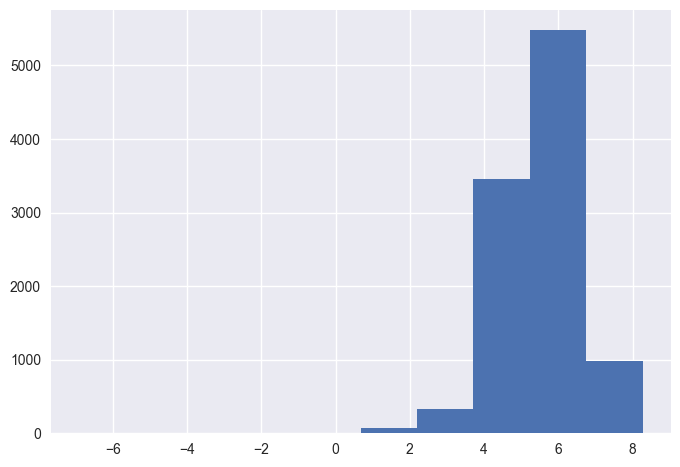

In [24]:
# удалите все выбросы для признака 'duration'
outliers, cleaned = outliers_iqr_mod(df, 'duration', log_scale=True
                                        )
print(f'Число выбросов по методу Тьюки: {outliers.shape[0]}')
print(f'Результирующее число записей: {cleaned.shape[0]}')

In [25]:
df = cleaned.copy()

<Axes: xlabel='deposit', ylabel='campaign'>

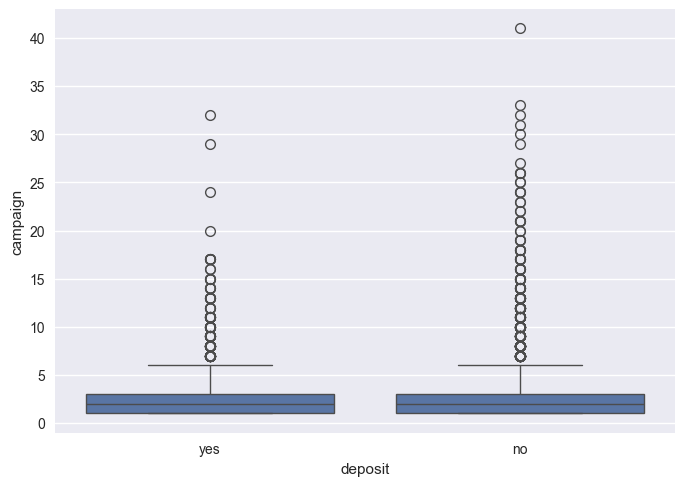

In [26]:
sns.boxplot(data=df, y='campaign', x='deposit')

выбросы уменьшились, дополнительных преобразований не нужно

## Часть 2:  Разведывательный анализ

### Задание 1

In [27]:
# Узнайте, для какого статуса предыдущей маркетинговой кампании успех в текущей превалирует над количеством неудач.
# ваш код
df.groupby("poutcome")['deposit'].value_counts(normalize=False).unstack()

deposit,no,yes
poutcome,,
failure,550,558
other,199,277
success,83,883
unknown,4481,3097


In [28]:
# Узнайте, для какого статуса предыдущей маркетинговой кампании успех в текущей превалирует над количеством неудач.
# ваш код
df.groupby(['poutcome', 'deposit'])['deposit'].count().unstack()

deposit,no,yes
poutcome,,
failure,550,558
other,199,277
success,83,883
unknown,4481,3097


In [29]:
# узнайте, в каком месяце чаще всего отказывались от предложения открыть депозит
# ваш код
df.groupby(['poutcome', 'month'])['deposit'].value_counts(normalize=False).unstack()

deposit             no    yes
poutcome month               
failure  apr      83.0   69.0
         aug      19.0   66.0
         dec       2.0   10.0
         feb      71.0   56.0
         jan      30.0    9.0
         jul       8.0   35.0
         jun      10.0   38.0
         mar       1.0   25.0
         may     208.0  118.0
         nov      92.0   49.0
         oct      17.0   46.0
         sep       9.0   37.0
other    apr      31.0   34.0
         aug      10.0   27.0
         dec       3.0   10.0
         feb      33.0   21.0
         jan      25.0   10.0
         jul       2.0   24.0
         jun       3.0   26.0
         mar       5.0   15.0
         may      57.0   48.0
         nov      20.0   20.0
         oct       3.0   18.0
         sep       7.0   24.0
success  apr       6.0   72.0
         aug      12.0  125.0
         dec       NaN   30.0
         feb      10.0   84.0
         jan       3.0   37.0
         jul       4.0   63.0
         jun      11.0   75.0
         mar       1.0   43.0
         may      13.0  106.0
         nov      15.0   74.0
         oct       6.0   86.0
         sep       2.0   88.0
unknown  apr     194.0  354.0
         aug     721.0  410.0
         dec       3.0   39.0
         feb     192.0  235.0
         jan     137.0   74.0
         jul     812.0  470.0
         jun     562.0  366.0
         mar      17.0  138.0
         may    1460.0  584.0
         nov     326.0  204.0
         oct      33.0  132.0
         sep      24.0   91.0

In [30]:
# узнайте, в каком месяце чаще всего отказывались от предложения открыть депозит
# ваш код
df.groupby([ 'month'])['deposit'].value_counts(normalize=True).unstack()

deposit,no,yes
month,,
apr,0.372479,0.627521
aug,0.548201,0.451799
dec,0.082474,0.917526
feb,0.435897,0.564103
jan,0.600000,0.400000
jul,0.582511,0.417489
jun,0.537122,0.462878
mar,0.097959,0.902041
may,0.670008,0.329992


In [31]:
labelencoder = LabelEncoder()
data_new = labelencoder.fit_transform(df['education'])
print(labelencoder.classes_)
print(np.unique(data_new, return_counts=True))

['primary' 'secondary' 'tertiary']
(array([0, 1, 2]), array([1349, 5497, 3282], dtype=int64))


In [32]:
# У education больше 2-х значений кодирование LabelEncoder() не подходит
#df['education']= data_new

<Axes: xlabel='age_group', ylabel='count'>

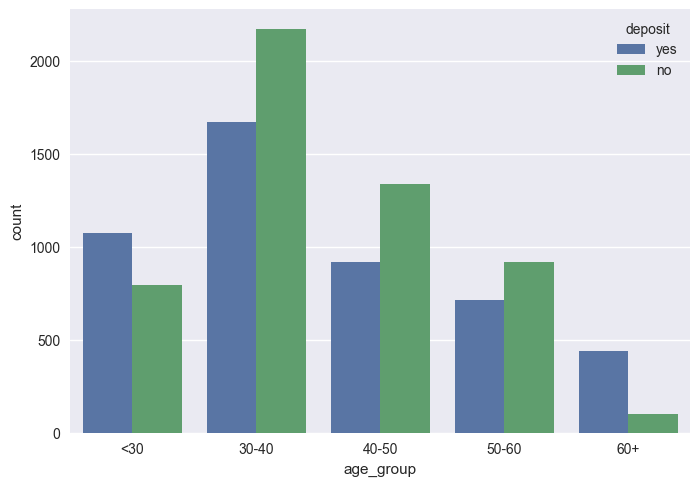

In [33]:
# создайте возрастные группы и определите, в каких группах более склонны открывать депозит, чем отказываться от предложения
df['age_group'] = pd.cut(df.age, [0,30,40,50,60,9999], labels = ['<30','30-40','40-50','50-60','60+'])
sns.countplot(x="age_group", hue="deposit", data=df)

In [34]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от семейного статуса
df['marital'].value_counts()

married     5742
single      3197
divorced    1189
Name: marital, dtype: int64

In [35]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от образования
df['job'].value_counts()

management       2272
blue-collar      1782
technician       1645
admin.           1255
services          867
retired           680
self-employed     359
unemployed        328
student           328
entrepreneur      297
housemaid         253
unknown            62
Name: job, dtype: int64

<Axes: xlabel='pdays_cat', ylabel='count'>

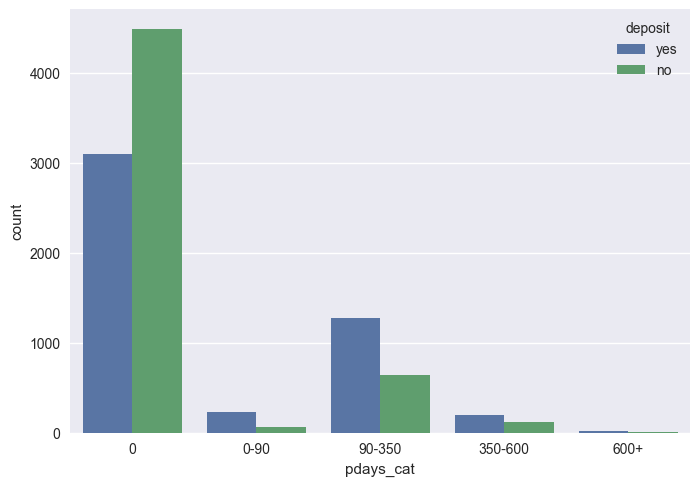

In [36]:
df['pdays_cat'] = pd.cut(df['pdays'], [-5,0, 90,350,600,9999], labels = ['0','0-90','90-350','350-600','600+'])
sns.countplot(x='pdays_cat', hue="deposit", data=df)

In [37]:
# постройте сводную таблицу, чтобы определить люди с каким образованием и семейным статусом наиболее многочисленны
#(если рассматривать тех, кто открыл депозит)   
df_no = df[df['deposit'] == 'no'].groupby(['marital'])['education'].value_counts().unstack()
df_no

education,primary,secondary,tertiary
marital,,,
divorced,91,362,163
married,635,1784,828
single,91,836,523


In [38]:
df_yes = df[df['deposit'] != 'no'].groupby(['marital'])['education'].value_counts().unstack()
df_yes

education,primary,secondary,tertiary
marital,,,
divorced,99,295,179
married,352,1322,821
single,81,898,768


<Axes: xlabel='education', ylabel='marital'>

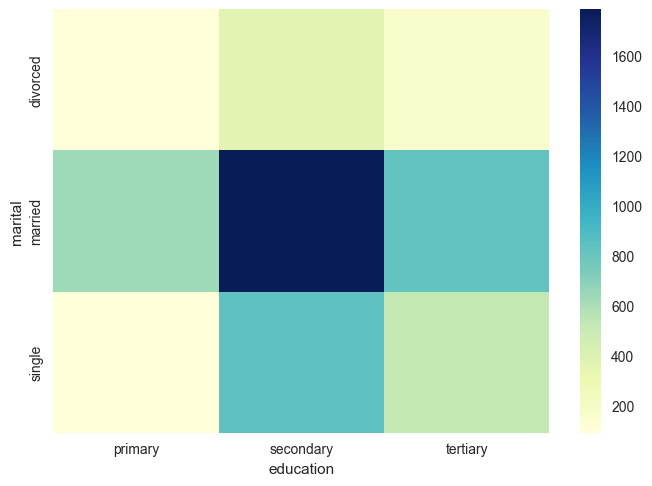

In [39]:
sns.heatmap(data=df_no, cmap='YlGnBu')

<Axes: xlabel='education', ylabel='marital'>

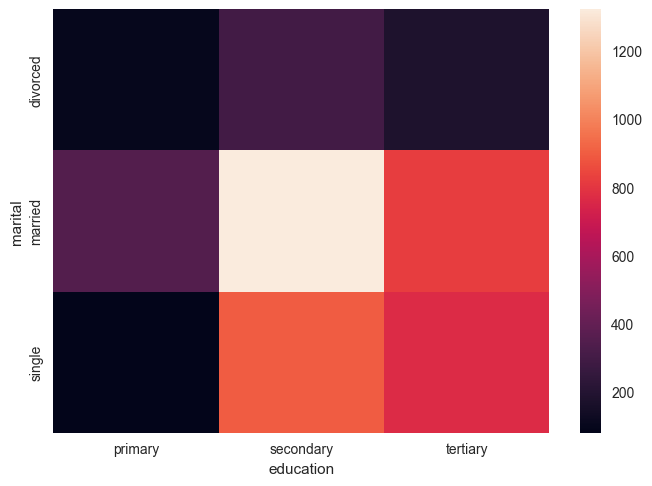

In [40]:
sns.heatmap(df_yes)

In [41]:
# преобразуйте уровни образования
labelencoder = LabelEncoder()
data_new = labelencoder.fit_transform(df['education'])
print(labelencoder.classes_)
print(np.unique(data_new, return_counts=True))

['primary' 'secondary' 'tertiary']
(array([0, 1, 2]), array([1349, 5497, 3282], dtype=int64))


In [42]:
# У education больше 2-х значений кодирование LabelEncoder() оно подходит, 
# так как в данном случае(совпало) сортирует в порядке уровней образования
df['education']= data_new

In [43]:
# Кодирование группы возраста
ordinalencoder = OrdinalEncoder(categories = [['<30','30-40','40-50','50-60','60+']])
data_new = ordinalencoder.fit_transform(df['age_group'].to_frame())
df['age_group'] = data_new
df['age_group'].value_counts()

1.0    3840
2.0    2255
0.0    1864
3.0    1630
4.0     539
Name: age_group, dtype: int64

### Задания 2 и 3

In [44]:
# перекодируем бинарные признаки 
for i in cat_features:
    if df[i].nunique() == 2:
        df[i] = labelencoder.fit_transform(df[i])

### Задание 4

In [45]:
# создайте дамми-переменные

In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10128 entries, 0 to 11161
Data columns (total 19 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   age        10128 non-null  int64   
 1   job        10128 non-null  object  
 2   marital    10128 non-null  object  
 3   education  10128 non-null  int32   
 4   default    10128 non-null  int32   
 5   balance    10128 non-null  float64 
 6   housing    10128 non-null  int32   
 7   loan       10128 non-null  int32   
 8   contact    10128 non-null  object  
 9   day        10128 non-null  int64   
 10  month      10128 non-null  object  
 11  duration   10128 non-null  int64   
 12  campaign   10128 non-null  int64   
 13  pdays      10128 non-null  int64   
 14  previous   10128 non-null  int64   
 15  poutcome   10128 non-null  object  
 16  deposit    10128 non-null  int32   
 17  age_group  10128 non-null  float64 
 18  pdays_cat  10128 non-null  category
dtypes: category(1), float64(2

In [47]:
# просмотр категориальных переменных
types = df.dtypes
cat_features = list(types[((types == 'object') | (types == 'category'))].index) #категориальные признаки
cat_features

['job', 'marital', 'contact', 'month', 'poutcome', 'pdays_cat']

In [48]:
df_dum = df.copy()
df = pd.get_dummies(df_dum, columns =cat_features )

### Задания 5 и 6

<Axes: >

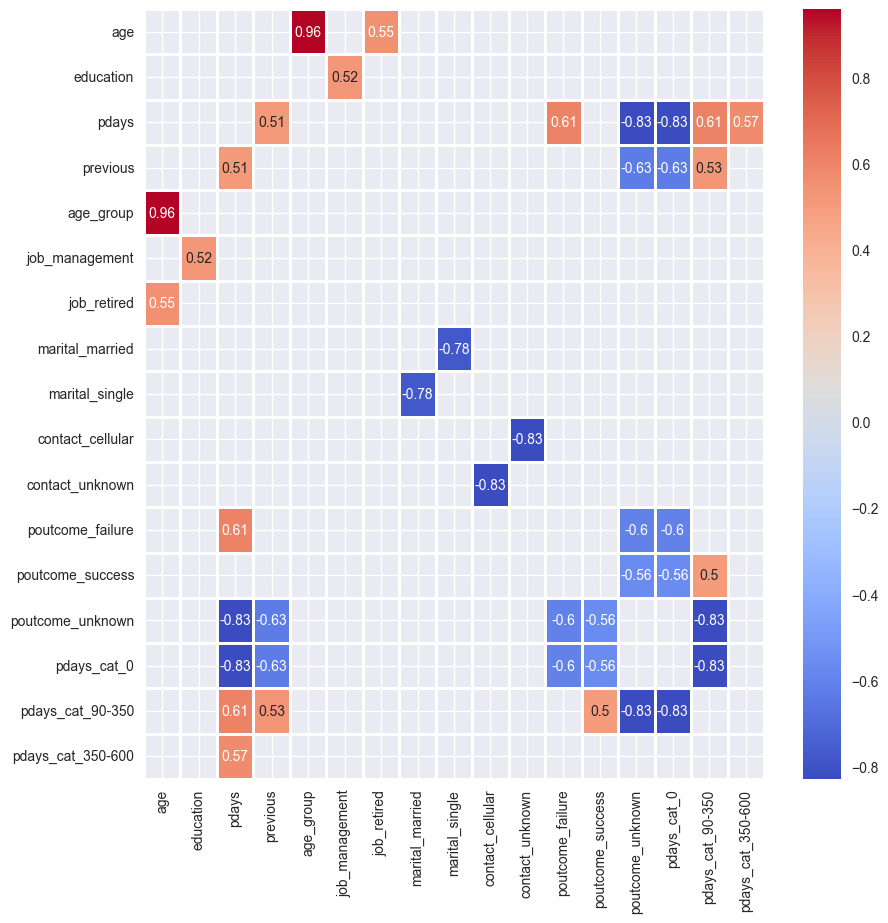

In [49]:
# постройте корреляционную матрицу и оцените данные на предмет наличия мультиколлинеарности
# Строим матрицу корреляций со значениями >0.5
pivot = df.copy()
pivot = round(pivot.corr( numeric_only=True), 2)
for col in pivot:
    pivot[col] = pivot[col].apply(
        lambda x: np.nan if (abs(x) < 0.5 or x == 1) else x)
for col in pivot:
    pivot = pivot.dropna(how='all')
    pivot = pivot.dropna(how='all', axis='columns')

plt.rcParams['figure.figsize'] = (10, 10)
sns.heatmap(pivot, annot=True, linewidths=.9, cmap='coolwarm')


<Axes: >

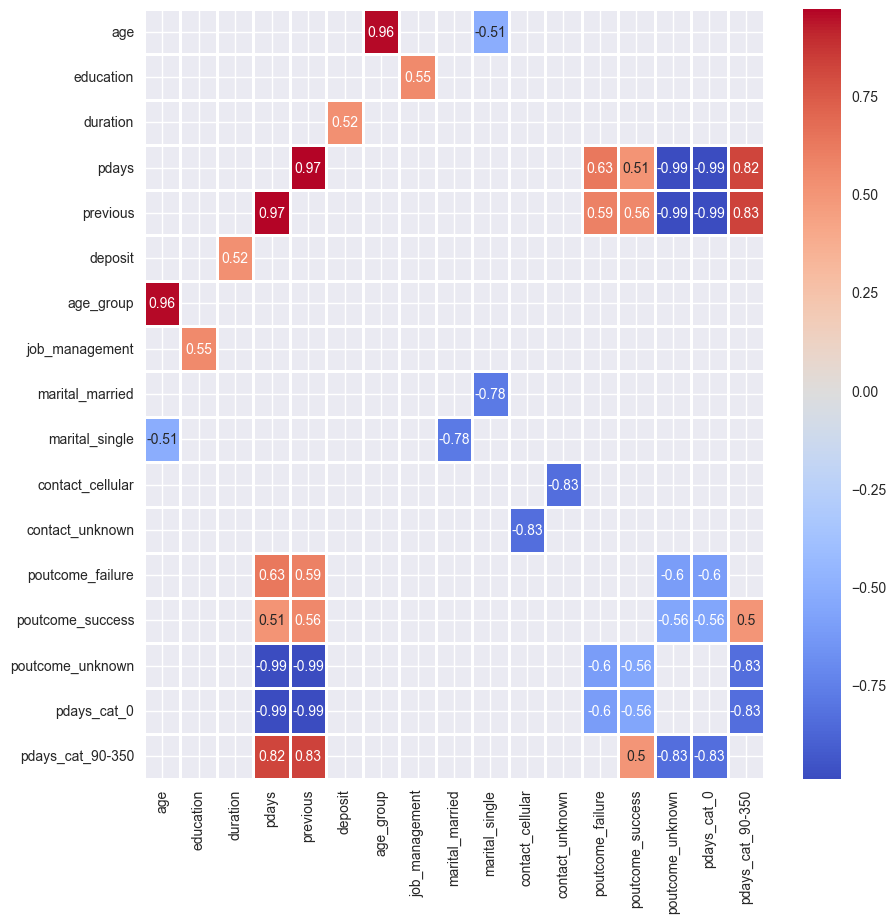

In [50]:
pivot = df.copy()
pivot = round(pivot.corr(method='spearman', numeric_only=True), 2)
for col in pivot:
    pivot[col] = pivot[col].apply(
        lambda x: np.nan if (abs(x) < 0.5 or x == 1) else x)
for col in pivot:
    pivot = pivot.dropna(how='all')
    pivot = pivot.dropna(how='all', axis='columns')

plt.rcParams['figure.figsize'] = (10, 10)
sns.heatmap(pivot, annot=True, linewidths=.9, cmap='coolwarm')


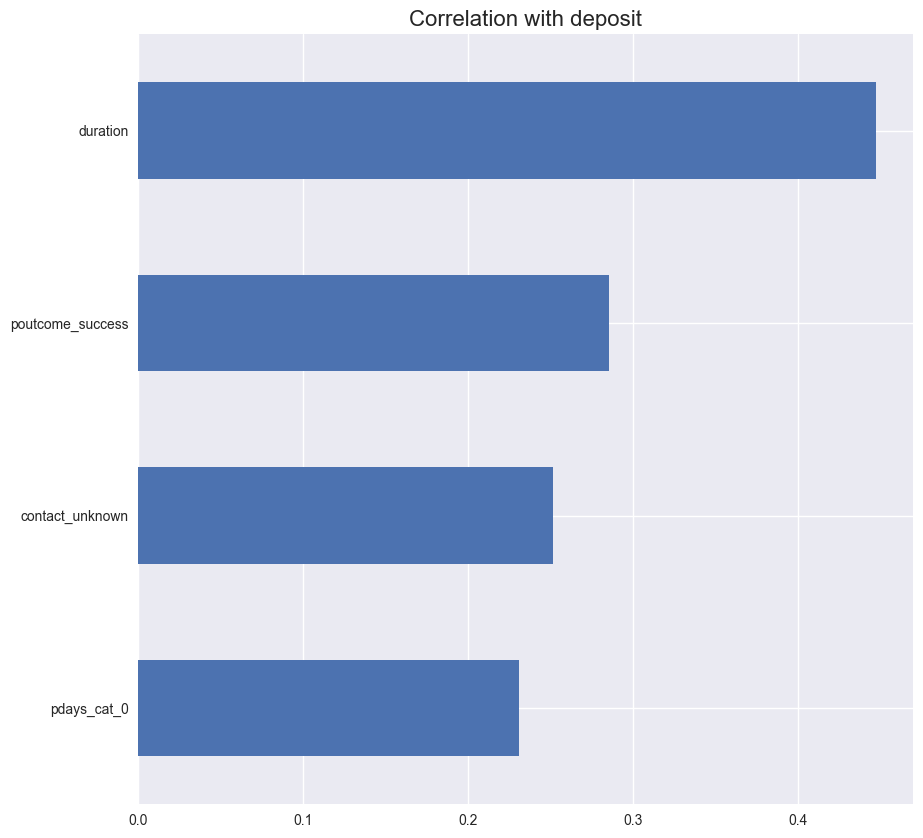

In [51]:
df.corr()["deposit"].apply(lambda x: abs(x)).sort_values()[-5:-1].plot.barh()
plt.title("Correlation with deposit", fontsize = 16)
plt.show()

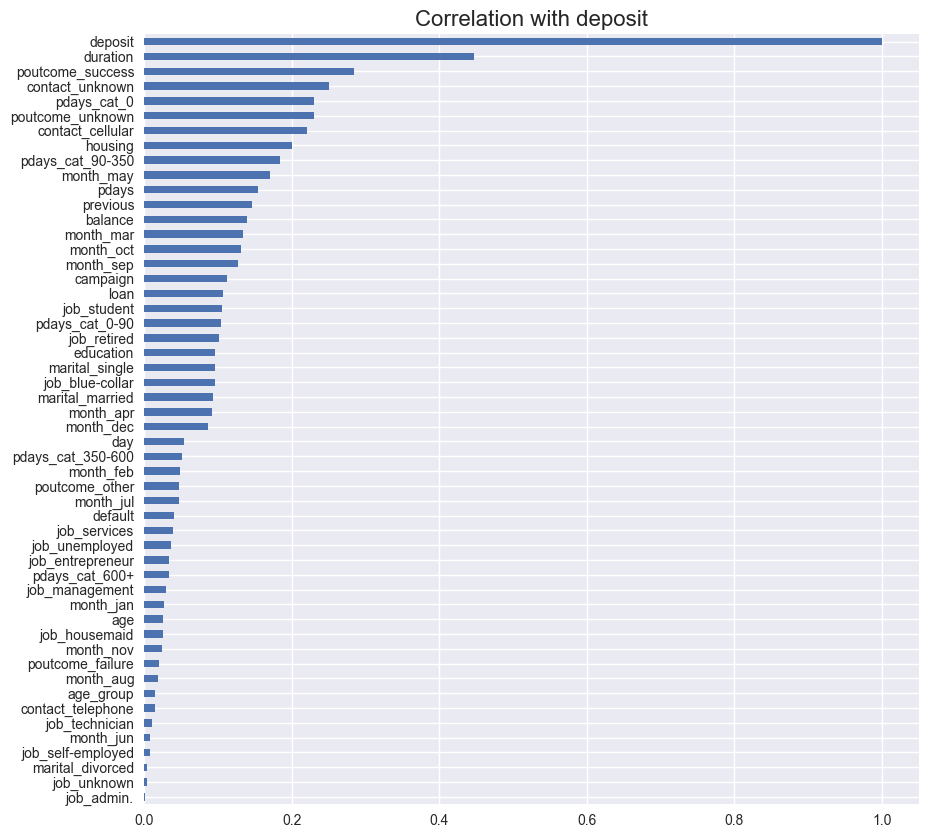

In [52]:
df.corr()["deposit"].apply(lambda x: abs(x)).sort_values()[:].plot.barh()
plt.title("Correlation with deposit", fontsize = 16)
plt.show()

Идеи

    1. удалить previous

    2. pdays разбить на интревалы

    3. Создать столбец наличия кредита (из двух или  трех стобцов?)
    
    4.Отсутвие образования в 30 лет и более

In [53]:
df['pdays'].describe()

count    10128.000000
mean        51.069017
std        108.620080
min         -1.000000
25%         -1.000000
50%         -1.000000
75%          6.500000
max        854.000000
Name: pdays, dtype: float64

In [54]:
df[df['pdays']>0]['pdays'].value_counts(bins=10, sort=False)

(0.146, 86.3]     205
(86.3, 171.6]     826
(171.6, 256.9]    727
(256.9, 342.2]    381
(342.2, 427.5]    317
(427.5, 512.8]     51
(512.8, 598.1]     22
(598.1, 683.4]      5
(683.4, 768.7]      5
(768.7, 854.0]     13
Name: pdays, dtype: int64

<Axes: xlabel='pdays_cat', ylabel='count'>

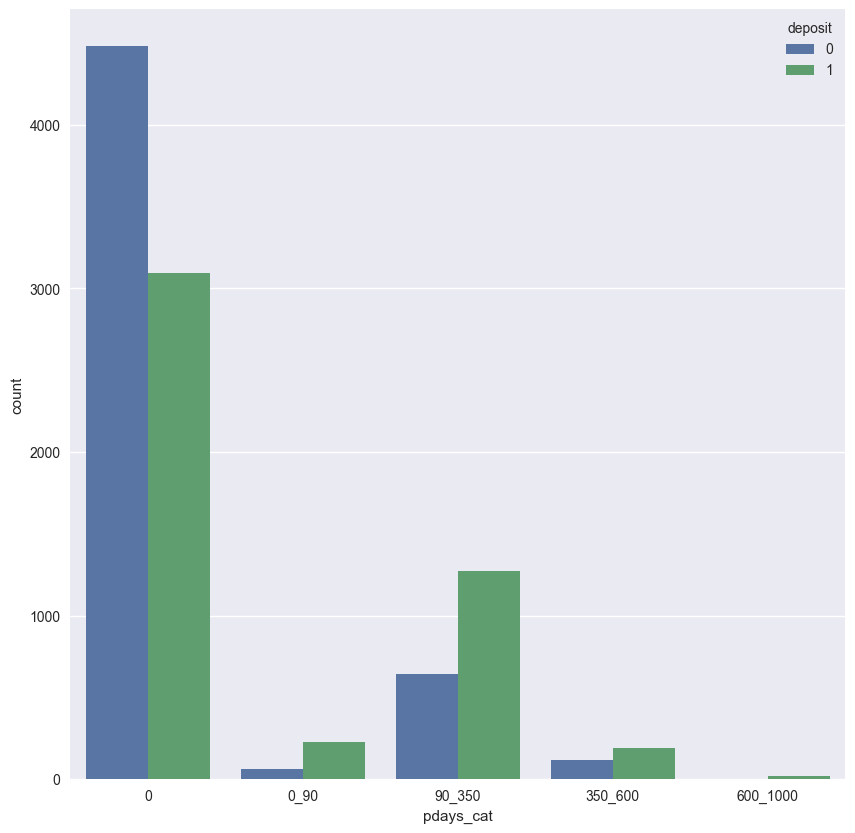

In [55]:
df['pdays_cat'] = pd.cut(df['pdays'], [-5,0, 90,350,600,9999], labels = ['0','0_90','90_350','350_600','600_1000'])
sns.countplot(x='pdays_cat', hue="deposit", data=df)

In [56]:
# удаляем скорректированные признаки
df = df.drop(['age', 'pdays'], axis=1)

### Задания 7 и 8

In [57]:
X = df.drop(['deposit'], axis=1)
y = df['deposit']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

### Задание 9

In [58]:
# с помощью SelectKBest отберите 15 наиболее подходящих признаков
selector = SelectKBest(f_classif, k=15)
selector.fit(X_train, y_train)
 
feature_best = list(selector.get_feature_names_out())
feature_best


['balance',
 'housing',
 'duration',
 'campaign',
 'previous',
 'contact_cellular',
 'contact_unknown',
 'month_mar',
 'month_may',
 'month_oct',
 'month_sep',
 'poutcome_success',
 'poutcome_unknown',
 'pdays_cat_0',
 'pdays_cat_90-350']

In [59]:
X_train = X_train[feature_best]
X_test = X_test[feature_best]

### Задание 10

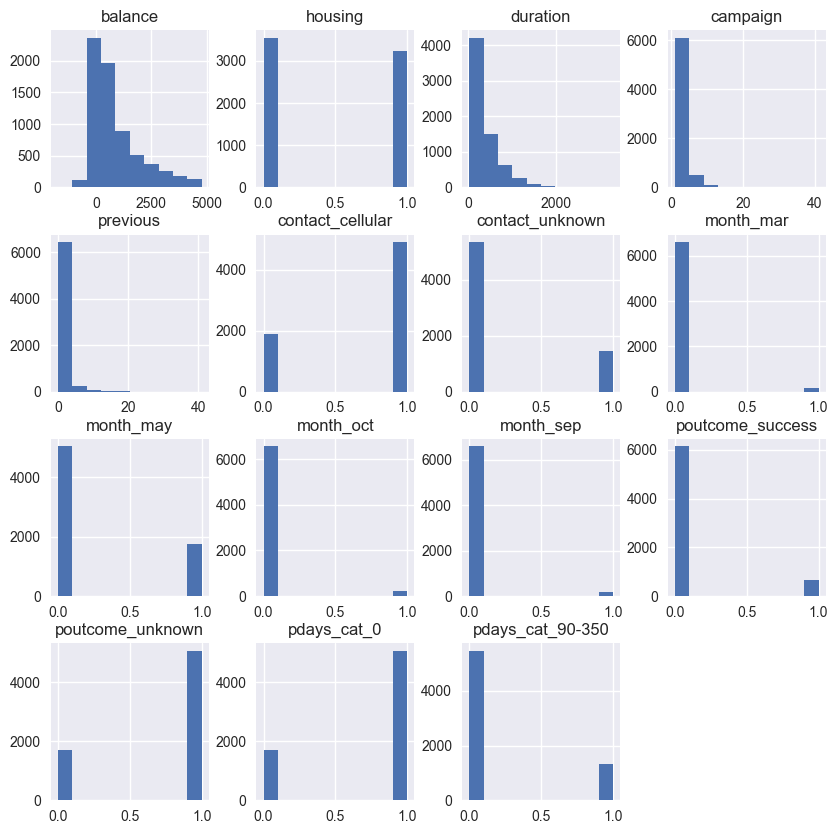

In [60]:
# нормализуйте данные с помощью minmaxsxaler
X_train.hist();

In [61]:
# X_train['duration'] = np.log(X_train['duration']  + 0.001)
# X_test['duration'] = np.log(X_test['duration'] + 0.001)

In [62]:
scaler = preprocessing.MinMaxScaler()
scaler.fit(X_train)                           # fit() только на train данных
X_train_scaled = scaler.transform(X_train)    # fransform() на train данных
X_test_scaled = scaler.transform(X_test)      # fransform() на test данных

print(X_test_scaled[:, 0].mean())  # для признака balance, обратите внимание именно на столбец

0.40226662085708187


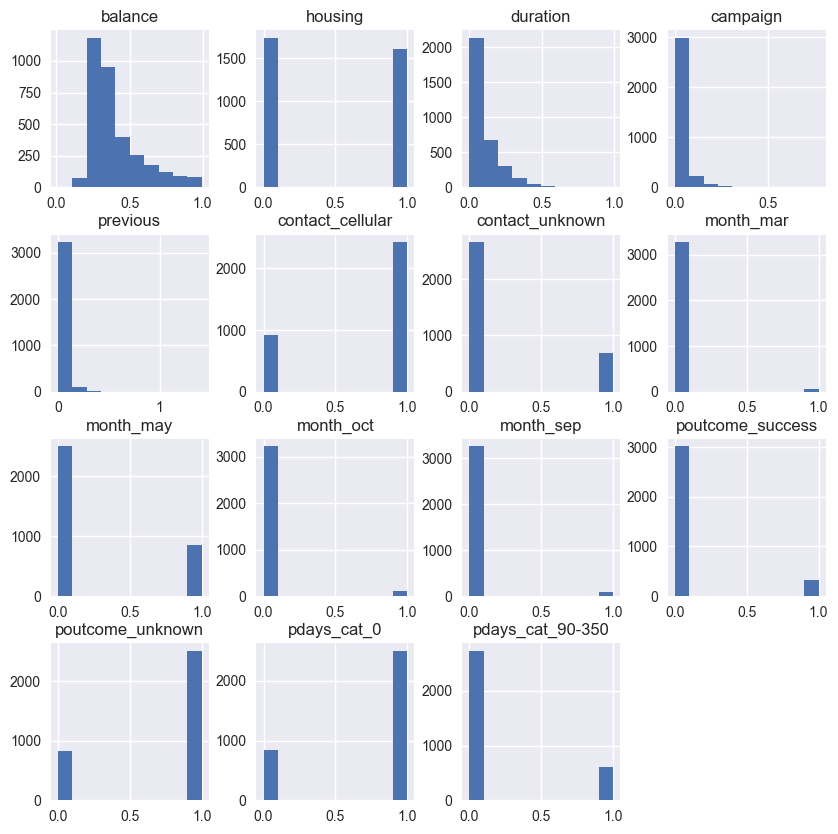

In [63]:
pd.DataFrame(X_test_scaled, columns=feature_best).hist();

In [64]:
pd.DataFrame(X_test_scaled, columns=feature_best).describe()

,balance,housing,duration,campaign,previous,contact_cellular,contact_unknown,month_mar,month_may,month_oct,month_sep,poutcome_success,poutcome_unknown,pdays_cat_0,pdays_cat_90-350
count,3343.000000,3343.000000,3343.000000,3343.000000,3343.000000,3343.000000,3343.000000,3343.000000,3343.000000,3343.000000,3343.000000,3343.000000,3343.000000,3343.000000,3343.000000
mean,0.402267,0.479809,0.106545,0.036180,0.019794,0.725097,0.205504,0.018845,0.253066,0.034400,0.026025,0.097816,0.750523,0.750224,0.181573
std,0.175342,0.499667,0.104885,0.063384,0.058899,0.446532,0.404130,0.135999,0.434834,0.182282,0.159232,0.297111,0.432775,0.432948,0.385550
min,0.010059,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.278397,0.000000,0.036481,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000
50%,0.335500,0.000000,0.070815,0.025000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000
75%,0.469205,1.000000,0.142551,0.050000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000
max,0.993965,1.000000,0.990497,0.775000,1.414634,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

### Задание 1

In [65]:
# обучите логистическую регрессию и рассчитайте метрики качества
log_reg = linear_model.LogisticRegression(
    solver='sag', 
    random_state=42, 
    max_iter=1000 )

log_reg.fit(X_train_scaled, y_train)

LogisticRegression(max_iter=1000, random_state=42, solver='sag')

In [66]:
y_train_pred = log_reg.predict(X_train_scaled)
print('f1_score на обучающем наборе: {:.3f}'.format(
    metrics.f1_score(y_train, y_train_pred)))
print("accuracy на тестовом наборе: {:.3f}".format(
    log_reg.score(X_test_scaled, y_test)))
y_test_pred = log_reg.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.3f}'.format(
    metrics.f1_score(y_test, y_test_pred)))


f1_score на обучающем наборе: 0.793
accuracy на тестовом наборе: 0.806
f1_score на тестовом наборе: 0.782


### Задания 2,3,4

In [67]:
# обучите решающие деревья, настройте максимальную глубину
dt_clf= tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности 
    #max_depth=3, #максимальная глубина
    random_state=42 #генератор случайных чисел
)
#Обучаем дерево решений по алгоритму CART
dt_clf.fit(X_train_scaled, y_train)


DecisionTreeClassifier(criterion='entropy', random_state=42)

In [68]:
y_train_pred = dt_clf.predict(X_train_scaled)
print("accuracy на обучающем наборе: {:.3f}".format(
    dt_clf.score(X_train_scaled, y_train)))
print('f1_score на обучающем наборе: {:.3f}'.format(
    metrics.f1_score(y_train, y_train_pred)))
print("accuracy на тестовом наборе: {:.3f}".format(
    dt_clf.score(X_test_scaled, y_test)))
y_test_pred = dt_clf.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.3f}'.format(
    metrics.f1_score(y_test, y_test_pred)))

accuracy на обучающем наборе: 1.000
f1_score на обучающем наборе: 1.000
accuracy на тестовом наборе: 0.744
f1_score на тестовом наборе: 0.729


### Задание 5

In [69]:
# # подберите оптимальные параметры с помощью gridsearch
# max_depth = [2,3,4,5,6,7,8,9]

# for i in max_depth:
#     # обучите решающие деревья, настройте максимальную глубину
#     dt_clf= tree.DecisionTreeClassifier(
#         criterion='entropy', #критерий информативности 
#         max_depth=i, #максимальная глубина
#         random_state=42 #генератор случайных чисел
#         )
#     #Обучаем дерево решений по алгоритму CART
#     dt_clf.fit(X_train_scaled, y_train)

#     y_train_pred = dt_clf.predict(X_train_scaled)

#     print("accuracy на обучающем наборе: {:.2f}".format(
#             dt_clf.score(X_train_scaled, y_train)))
#     print("accuracy на тестовом наборе: {:.2f}".format(
#             dt_clf.score(X_test_scaled, y_test)))
#     print(dt_clf.score(X_train_scaled, y_train)-dt_clf.score(X_test_scaled, y_test))
#     print(f'-------{i}')
    

In [70]:
# подберите оптимальные параметры с помощью gridsearch
param_grid = {'min_samples_split': [2, 5, 7, 10],
              'max_depth':[3,5,7]
              }
            
grid_search_tree = GridSearchCV(
    estimator=tree.DecisionTreeClassifier(random_state=42), 
    param_grid=param_grid, 
    scoring='f1',
    cv=3, 
    n_jobs = -1
)  
%time grid_search_tree.fit(X_train_scaled, y_train) 
print("accuracy на тестовом наборе: {:.2f}".format(grid_search_tree.score(X_test_scaled, y_test)))
y_test_pred = grid_search_tree.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search_tree.best_params_))


CPU times: total: 297 ms
Wall time: 5.34 s
accuracy на тестовом наборе: 0.81
f1_score на тестовом наборе: 0.81
Наилучшие значения гиперпараметров: {'max_depth': 7, 'min_samples_split': 2}


# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

### Задание 1

In [72]:
# обучите на ваших данных случайный лес
rf = ensemble.RandomForestClassifier(
    n_estimators=100,
    criterion='gini',
    min_samples_leaf=5,
    max_depth=10,
    random_state=42
)
#Обучаем модель
rf.fit(X_train_scaled, y_train)

RandomForestClassifier(max_depth=10, min_samples_leaf=5, random_state=42)

In [73]:
y_train_pred = rf.predict(X_train_scaled)
print("accuracy на обучающем наборе: {:.3f}".format(
    rf.score(X_train_scaled, y_train)))
print('f1_score на обучающем наборе: {:.3f}'.format(
    metrics.f1_score(y_train, y_train_pred)))
print("accuracy на тестовом наборе: {:.3f}".format(
    rf.score(X_test_scaled, y_test)))
y_test_pred = rf.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.3f}'.format(
    metrics.f1_score(y_test, y_test_pred)))
print('Recall на тестовом наборе: {:.3f}'.format(
    metrics.recall_score(y_test, y_test_pred)))

accuracy на обучающем наборе: 0.844
f1_score на обучающем наборе: 0.840
accuracy на тестовом наборе: 0.821
f1_score на тестовом наборе: 0.812
Recall на тестовом наборе: 0.817


### Задания 2 и 3

In [74]:
# используйте для классификации градиентный бустинг и сравните качество со случайным лесом
from sklearn.ensemble import GradientBoostingClassifier

# Создаем объект класса градиентный бустинг
gb = GradientBoostingClassifier(
    
    learning_rate=0.05, 
    min_samples_leaf=5,
    max_depth=5, #максимальная глубина дерева
    n_estimators=300, #количество деревьев в ансамбле
    random_state=42, #датчик генератора случайных чисел

)

# Обучаем модель
gb.fit(X_train_scaled, y_train)


GradientBoostingClassifier(learning_rate=0.05, max_depth=5, min_samples_leaf=5,
                           n_estimators=300, random_state=42)

In [75]:
y_train_pred = gb.predict(X_train_scaled)
print("accuracy на обучающем наборе: {:.3f}".format(
    gb.score(X_train_scaled, y_train)))
print('f1_score на обучающем наборе: {:.3f}'.format(
    metrics.f1_score(y_train, y_train_pred)))
print("accuracy на тестовом наборе: {:.3f}".format(
    gb.score(X_test_scaled, y_test)))
y_test_pred = rf.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.3f}'.format(
    metrics.f1_score(y_test, y_test_pred)))
print('Recall на тестовом наборе: {:.3f}'.format(
    metrics.recall_score(y_test, y_test_pred)))

accuracy на обучающем наборе: 0.867
f1_score на обучающем наборе: 0.863
accuracy на тестовом наборе: 0.817
f1_score на тестовом наборе: 0.812
Recall на тестовом наборе: 0.817


### Задание 4

In [76]:
# объедините уже известные вам алгоритмы с помощью стекинга 
estimators = [
    ('dt', tree.DecisionTreeClassifier(
        criterion='entropy',
        min_samples_leaf=5,
        max_depth=6,
        random_state=42
        )
    ),
    ('log_reg', linear_model.LogisticRegression(
        solver='sag',
        random_state=42 
        )
    ),
    ('gb', ensemble.GradientBoostingClassifier(
        learning_rate=0.05,
        n_estimators=300,
        min_samples_leaf=5,
        max_depth=5,
        random_state=42
        )
    )
]

stack = ensemble.StackingClassifier(
    estimators,
    final_estimator=linear_model.LogisticRegression(random_state=42)
)
stack.fit(X_train_scaled, y_train)

StackingClassifier(estimators=[('dt',
                                DecisionTreeClassifier(criterion='entropy',
                                                       max_depth=6,
                                                       min_samples_leaf=5,
                                                       random_state=42)),
                               ('log_reg',
                                LogisticRegression(random_state=42,
                                                   solver='sag')),
                               ('gb',
                                GradientBoostingClassifier(learning_rate=0.05,
                                                           max_depth=5,
                                                           min_samples_leaf=5,
                                                           n_estimators=300,
                                                           random_state=42))],
                   final_estimator=LogisticRegression(random_state=42))

In [77]:
y_train_pred = stack.predict(X_train_scaled)
print("accuracy на обучающем наборе: {:.3f}".format(
   stack.score(X_train_scaled, y_train)))
print('f1_score на обучающем наборе: {:.3f}'.format(
    metrics.f1_score(y_train, y_train_pred)))
print("accuracy на тестовом наборе: {:.3f}".format(
    stack.score(X_test_scaled, y_test)))
y_test_pred = rf.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.3f}'.format(
    metrics.f1_score(y_test, y_test_pred)))
print('Recall на тестовом наборе: {:.3f}'.format(
    metrics.recall_score(y_test, y_test_pred)))
print('precision на тестовом наборе: {:.3f}'.format(
    metrics.precision_score(y_test, y_test_pred)))

accuracy на обучающем наборе: 0.853
f1_score на обучающем наборе: 0.846
accuracy на тестовом наборе: 0.818
f1_score на тестовом наборе: 0.812
Recall на тестовом наборе: 0.817
precision на тестовом наборе: 0.807


### Задание 5

In [78]:
# оцените, какие признаки демонстрируют наибольшую  важность в модели градиентного бустинга
gb.feature_importances_

array([0.08329995, 0.05018471, 0.49412804, 0.02311917, 0.02830452,
       0.00257264, 0.08149499, 0.03621109, 0.01695415, 0.01984806,
       0.01579401, 0.12886257, 0.00207595, 0.0148742 , 0.00227594])

<Axes: >

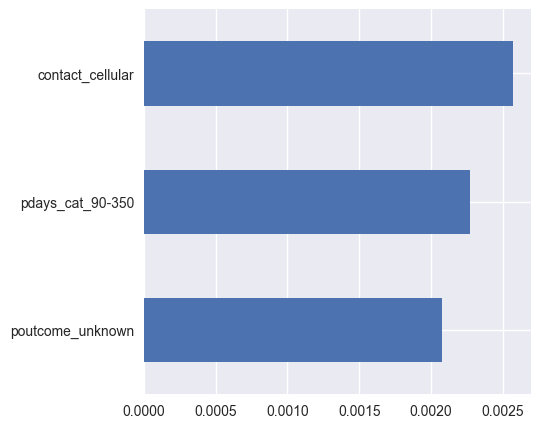

In [81]:
# оцените, какие признаки демонстрируют наибольшую  важность в модели градиентного бустинга
plt.rcParams['figure.figsize'] = (5, 5)
feat_importances = pd.Series(gb.feature_importances_, index=X_test.columns)
feat_importances.sort_values().head(3).plot(kind='barh')


### Задания 6,7,8

In [82]:
# реализуйте оптимизацию гиперпараметров с помощью Optuna

In [83]:
import optuna
from sklearn.model_selection import cross_val_score, StratifiedKFold  # кросс-валидациz

In [84]:
# импорт модулей для игнорирование информационных сообщений
from sklearn.utils._testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning

In [85]:
# реализуйте оптимизацию гиперпараметров с помощью Optuna
@ignore_warnings(category=ConvergenceWarning) # убираем предупреждения
def optuna_rf(trial):
    """ Вспомогательная функция для подбора гиперпараметров RF с кросс-валидацией

    Args:
        trial: Пространство гиперпараметров
    Returns: средняя точность на кросс-валидации
    """
    # задаем пространства поиска гиперпараметров
    n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
    max_depth = trial.suggest_int('max_depth', 10, 30, 1)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)
    #criterion = trial.suggest_categorical('criterion', ['entropy', 'gini'])

    # создаем модель
    model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                            max_depth=max_depth,
                                            min_samples_leaf=min_samples_leaf,
                                            #criterion=criterion,
                                            random_state=42)
    # обучаем модель
    model.fit(X_train_scaled, y_train)
    score = cross_val_score(model, X=X_train_scaled, y=y_train, cv=5,
                            scoring="f1", n_jobs=-1)
    
    return score.mean()

In [86]:
%%time

optuna.logging.set_verbosity(optuna.logging.ERROR) # убираем всю информацию об итерациях
#optuna.logging.set_verbosity(optuna.logging.INFO) # возвращаем всю информацию об итерациях
# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study = optuna.create_study(study_name="RF", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз

study.optimize(optuna_rf, n_trials=200, n_jobs=-1, show_progress_bar=True)

  0%|          | 0/200 [00:00<?, ?it/s]

CPU times: total: 8min 15s
Wall time: 6min 14s


In [87]:
# выводим результаты на обучающей выборке
print("Наилучшие значения гиперпараметров {}".format(study.best_params))
print("f1_score на обучающем наборе: {:.3f}".format(study.best_value))


Наилучшие значения гиперпараметров {'n_estimators': 168, 'max_depth': 14, 'min_samples_leaf': 2}
f1_score на обучающем наборе: 0.819


In [88]:
# рассчитаем точность для тестовой выборки

model = ensemble.RandomForestClassifier(
    **study.best_params, random_state=42)
model.fit(X_train_scaled, y_train)
y_train_pred = model.predict(X_train_scaled)
print("accuracy на тестовом наборе: {:.3f}".format(
    model.score(X_test_scaled, y_test)))
y_test_pred = model.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.3f}'.format(
    metrics.f1_score(y_test, y_test_pred)))


accuracy на тестовом наборе: 0.819
f1_score на тестовом наборе: 0.813
